# 论文1：复杂动力学的第一定律
## Scott Aaronson

### 实现：元胞自动机与熵增长

本笔记本演示了封闭系统中复杂度和熵如何通过元胞自动机增长。

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]

# 解决负号显示问题
plt.rcParams["axes.unicode_minus"] = False

## 一维元胞自动机（规则30 - 混沌）

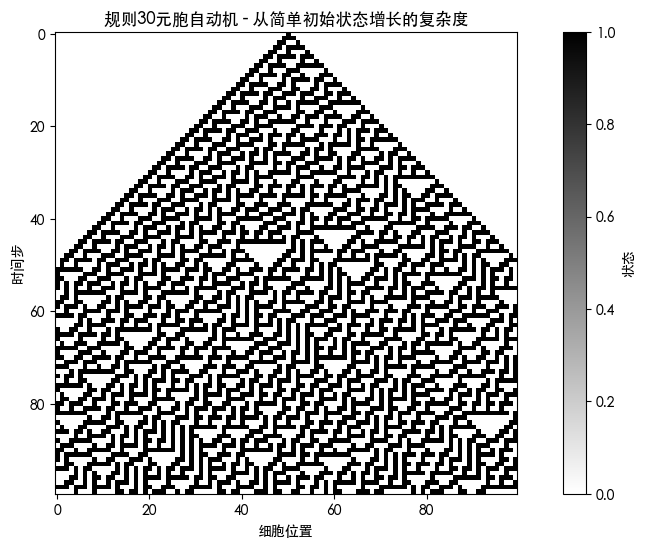

In [13]:
def rule_30(left, center, right):
    """规则30：生成复杂的、混沌的模式"""
    pattern = (left << 2) | (center << 1) | right
    rule = 30
    return (rule >> pattern) & 1

def evolve_ca(initial_state, steps, rule_func):
    """演化元胞自动机"""
    size = len(initial_state)
    history = np.zeros((steps, size), dtype=int)
    history[0] = initial_state
    
    for t in range(1, steps):
        for i in range(size):
            left = history[t-1, (i-1) % size]
            center = history[t-1, i]
            right = history[t-1, (i+1) % size]
            history[t, i] = rule_func(left, center, right)
    
    return history

# 简单的初始状态
size = 100
initial = np.zeros(size, dtype=int)
initial[size // 2] = 1  # 中心单个细胞

# 演化
steps = 100
evolution = evolve_ca(initial, steps, rule_30)

plt.figure(figsize=(12, 6))
plt.imshow(evolution, cmap='binary', interpolation='nearest')
plt.title('规则30元胞自动机 - 从简单初始状态增长的复杂度')
plt.xlabel('细胞位置')
plt.ylabel('时间步')
plt.colorbar(label='状态')
plt.show()

## 通过熵测量复杂度增长

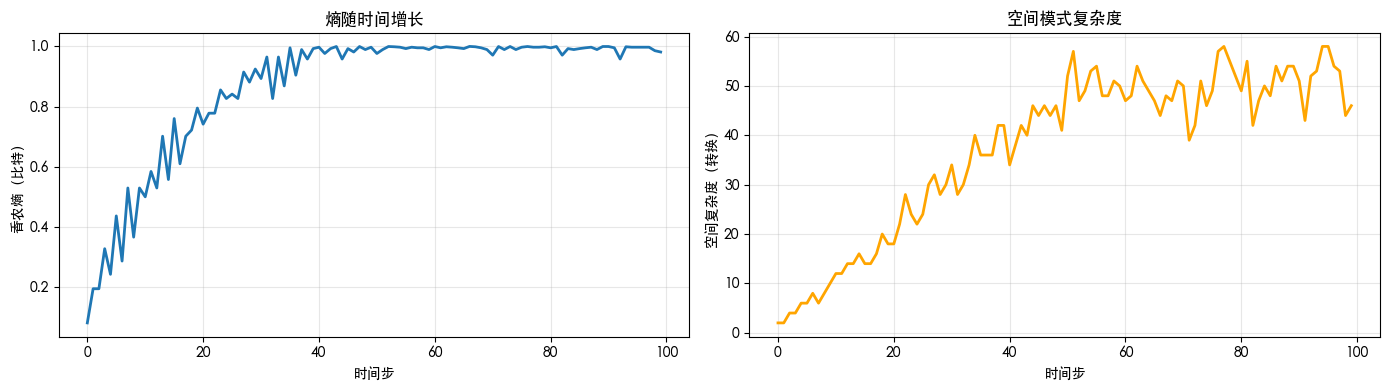

初始熵: 0.0808 比特
最终熵: 0.9815 比特
熵增长: 0.9007 比特


In [14]:
def measure_entropy_over_time(history):
    """测量每个时间步的香农熵"""
    entropies = []
    
    for t in range(len(history)):
        state = history[t]
        # 计算概率分布
        unique, counts = np.unique(state, return_counts=True)
        probs = counts / len(state)
        ent = entropy(probs, base=2)
        entropies.append(ent)
    
    return np.array(entropies)

def measure_spatial_complexity(history):
    """测量空间模式复杂度（转换次数）"""
    complexities = []
    
    for t in range(len(history)):
        state = history[t]
        # 计算相邻细胞之间的转换
        transitions = np.sum(np.abs(np.diff(state)))
        complexities.append(transitions)
    
    return np.array(complexities)

entropies = measure_entropy_over_time(evolution)
complexities = measure_spatial_complexity(evolution)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(entropies, linewidth=2)
ax1.set_xlabel('时间步')
ax1.set_ylabel('香农熵（比特）')
ax1.set_title('熵随时间增长')
ax1.grid(True, alpha=0.3)

ax2.plot(complexities, linewidth=2, color='orange')
ax2.set_xlabel('时间步')
ax2.set_ylabel('空间复杂度（转换）')
ax2.set_title('空间模式复杂度')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"初始熵: {entropies[0]:.4f} 比特")
print(f"最终熵: {entropies[-1]:.4f} 比特")
print(f"熵增长: {entropies[-1] - entropies[0]:.4f} 比特")

## 咖啡自动机：不可逆混合

演示简单的初始状态如何演化成复杂的模式（就像奶油在咖啡中混合），但逆过程几乎不可能发生。

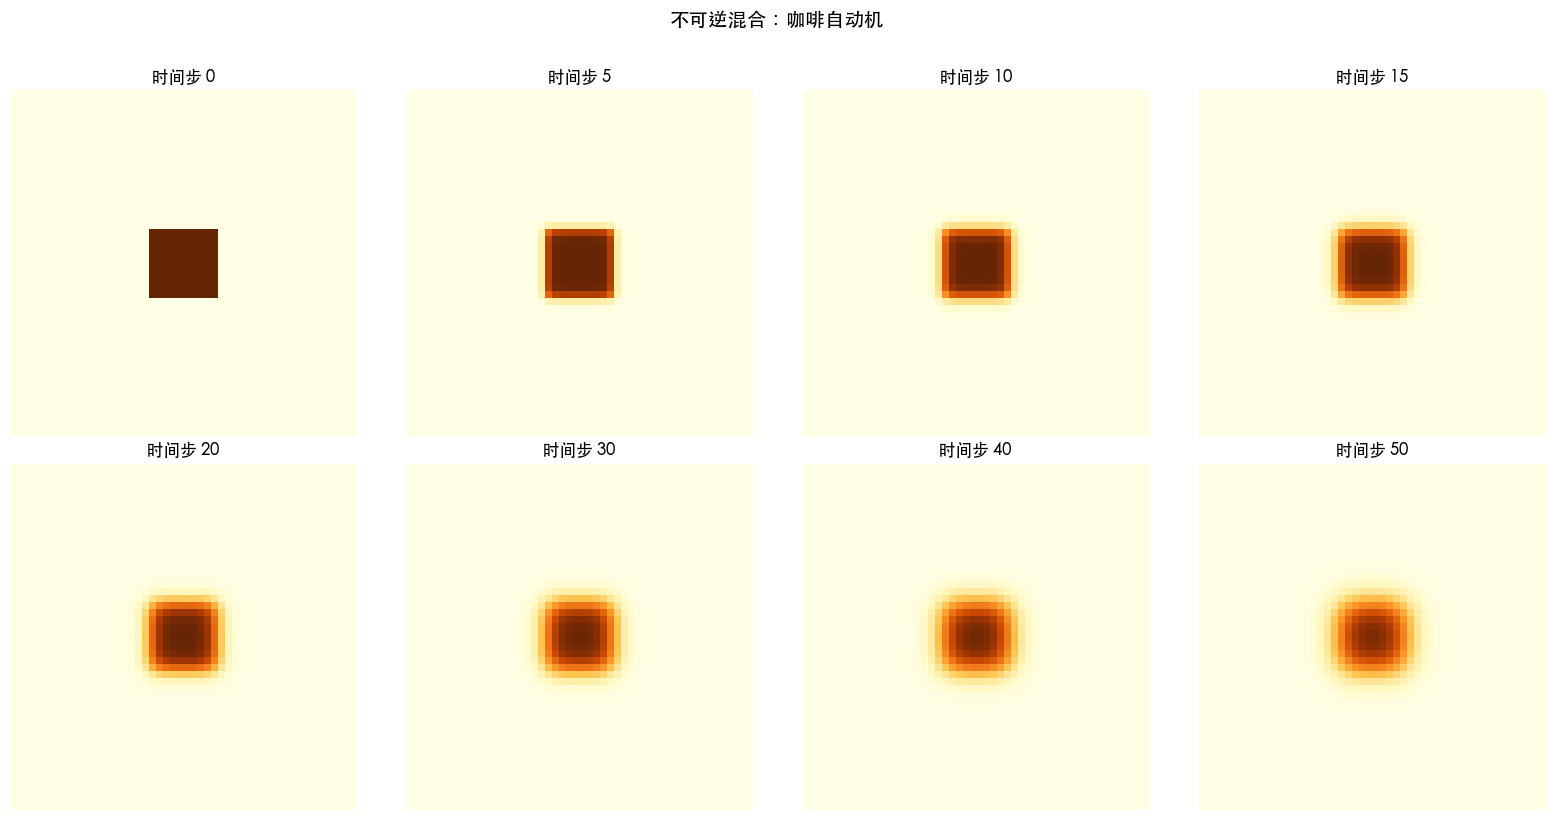

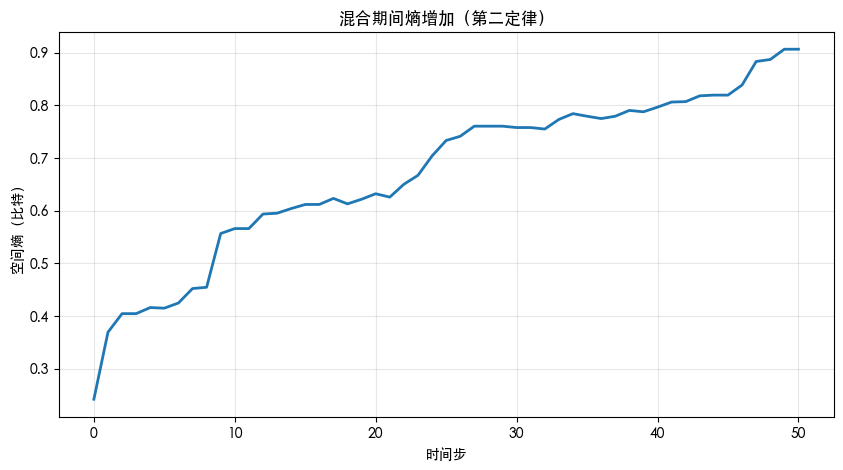


关键洞察：简单的集中状态 → 复杂的混合状态
这个过程是不可逆的：你无法将咖啡分离回来！


In [15]:
def diffusion_2d(grid, steps, diffusion_rate=0.1):
    """简单的二维扩散模拟"""
    history = [grid.copy()]
    
    for _ in range(steps):
        new_grid = grid.copy()
        h, w = grid.shape
        
        for i in range(1, h-1):
            for j in range(1, w-1):
                # 与邻居平均
                neighbors = (
                    grid[i-1, j] + grid[i+1, j] + 
                    grid[i, j-1] + grid[i, j+1]
                ) / 4
                new_grid[i, j] = (
                    (1 - diffusion_rate) * grid[i, j] + 
                    diffusion_rate * neighbors
                )
        
        grid = new_grid
        history.append(grid.copy())
    
    return np.array(history)

# 创建初始状态：咖啡中集中的"奶油"
size = 50
grid = np.zeros((size, size))
grid[20:30, 20:30] = 1.0  # 集中的区域

# 模拟混合
mixing_history = diffusion_2d(grid, steps=50, diffusion_rate=0.2)

# 可视化混合过程
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
timesteps = [0, 5, 10, 15, 20, 30, 40, 50]

for idx, (ax, t) in enumerate(zip(axes.flat, timesteps)):
    ax.imshow(mixing_history[t], cmap='YlOrBr', vmin=0, vmax=1)
    ax.set_title(f'时间步 {t}')
    ax.axis('off')

plt.suptitle('不可逆混合：咖啡自动机', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# 测量混合过程中的熵增长
mixing_entropies = []
for t in range(len(mixing_history)):
    flat = mixing_history[t].flatten()
    # 离散化用于熵计算
    bins = np.histogram(flat, bins=20)[0]
    probs = bins[bins > 0] / bins.sum()
    mixing_entropies.append(entropy(probs, base=2))

plt.figure(figsize=(10, 5))
plt.plot(mixing_entropies, linewidth=2)
plt.xlabel('时间步')
plt.ylabel('空间熵（比特）')
plt.title('混合期间熵增加（第二定律）')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n关键洞察：简单的集中状态 → 复杂的混合状态")
print(f"这个过程是不可逆的：你无法将咖啡分离回来！")

## 关键要点

1. **复杂度增长**：简单的初始状态演化成复杂的模式
2. **熵增**：封闭系统倾向于更高的熵（热力学第二定律）
3. **不可逆性**：复杂状态不太可能自发返回简单状态
4. **计算不可逆性**：咖啡自动机展示了基本限制

这与深度学习的联系：
- 信息论的理解
- 学习表示的复杂性
- 损失函数和正则化中的熵